In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import itertools
import matplotlib.dates as mdate

warnings.filterwarnings("ignore")
def load_unit_data(unit):
    unit_name = "000{}".format(unit) if unit < 10 else "00{}".format(unit)
    return pd.read_csv("../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit_name), index_col=0)

def get_last_proportion(unit, feature, proportion=0.1):
    df_unit = load_unit_data(unit)
    index_prop = int(len(df_unit.index) * (1- proportion))
    return df_unit[index_prop: ]

def plot_feature_in_single_file(feature_name, unit, ylim_low=-20, ylim_high=3000, bins=20, show_dist=True):
    file_df = load_unit_data(unit)
    file_df.set_index('timestamp', inplace=True)
    sns.set()
    fig, axs = plt.subplots(2 if show_dist else 1, 1, figsize=(16, 10))
    subplot_idx = 211 if show_dist else 111
    ax1 = fig.add_subplot(subplot_idx)
    if ylim_low is None and ylim_high is None:
        file_df[feature_name].plot()
    else:
        file_df[feature_name].plot(ylim=(ylim_low, ylim_high))

    xticks_count = 30
    xtick_dates_indexes = [int(n) for n in np.arange(0, len(file_df.index), step=len(file_df.index) / xticks_count)]
    xticks_dates = [datetime.datetime.strptime(file_df.index[i][:19], '%Y-%m-%d %H:%M:%S') for i in xtick_dates_indexes]
    #plt.xticks(np.arange(xticks_count), ["{}/{}".format(dt.year, dt.month) for dt in xticks_dates]) 
    #ax1.set_xticks(np.arange(0, 100, 10)) 

    if show_dist == True:
        ax2 = fig.add_subplot(212)
        sns.distplot(file_df[feature_name], bins=bins)
    plt.show()


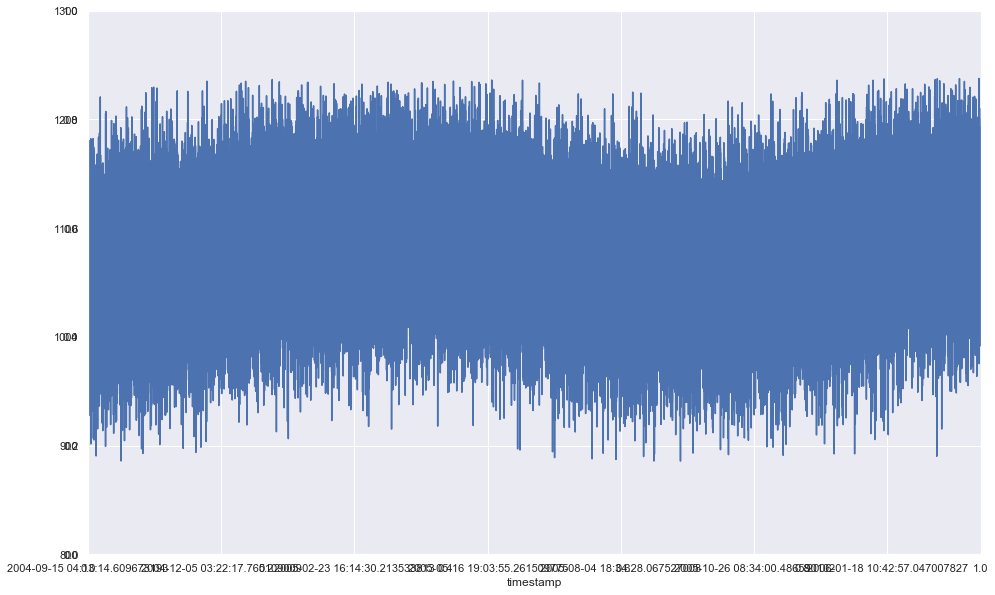

In [61]:
plot_feature_in_single_file("rpm", 12, ylim_low=800, ylim_high=1300, bins=100, show_dist=False)

In [55]:
df = load_unit_data(0)
df.set_index('timestamp', inplace=True)
df.index[5][:19]
xtick_dates_indexes = [int(n) for n in np.arange(0, len(df.index), step=len(df.index)/30)]
xticks_dates = [datetime.datetime.strptime(df.index[i][:19], '%Y-%m-%d %H:%M:%S') for i in xtick_dates_indexes]

np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

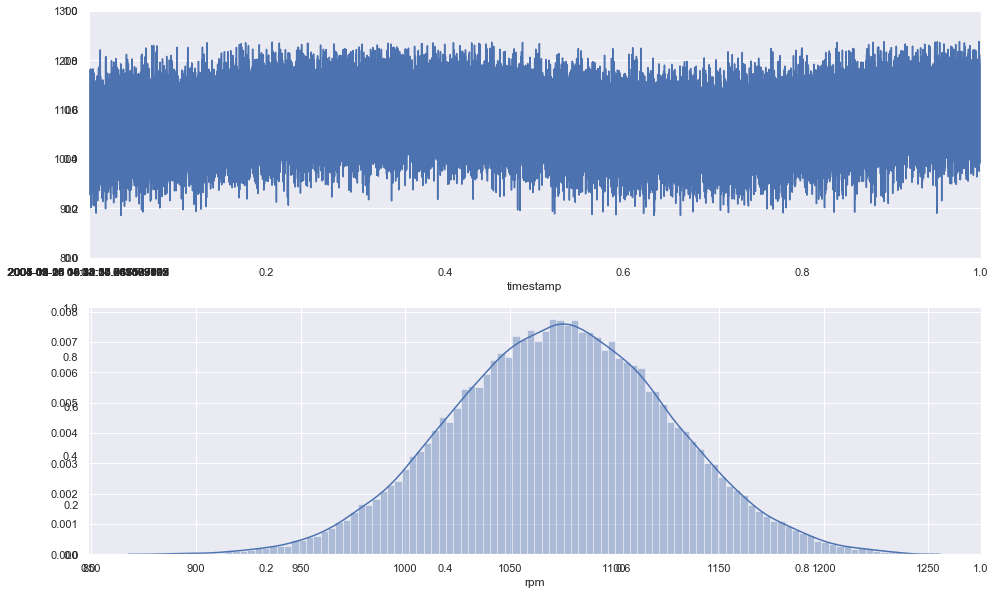

In [54]:
plot_feature_in_single_file("rpm", 12, ylim_low=800, ylim_high=1300, bins=100, show_dist=True)

ARIMA

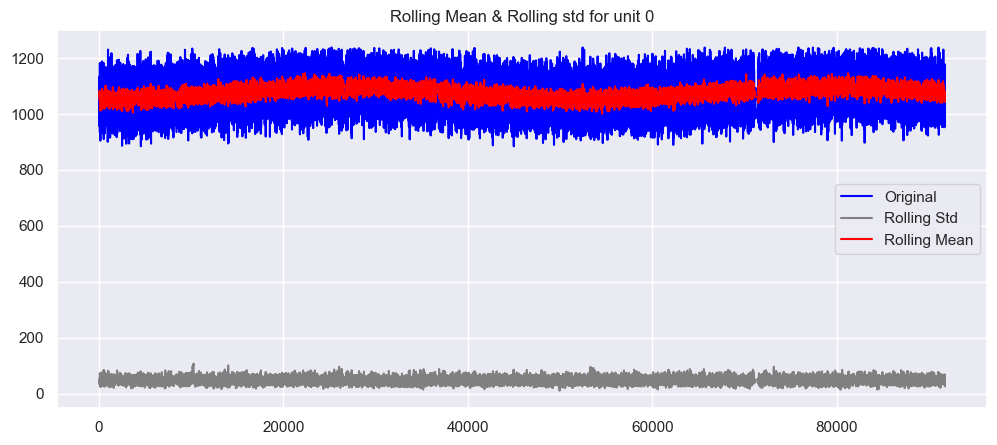

In [81]:
def plot_rolling_mean_std(unit, feature, window=12, ylim_low=-10, ylim_high=1500, figsize=None):
    df_unit = load_unit_data(unit)[[feature]]
    rolling_mean = df_unit.rolling(window=window).mean()
    rolling_std = df_unit.rolling(window=window).std()

    plt.figure(figsize=figsize, dpi=100)
    plt.plot(df_unit, color='blue', label='Original')
    plt.plot(rolling_std, color='grey', label='Rolling Std')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt_title = 'Rolling Mean & Rolling std for unit {}'.format(unit)
    plt.title(plt_title)
    plt.show()

plot_rolling_mean_std(0, 'rpm', figsize=(12, 5))

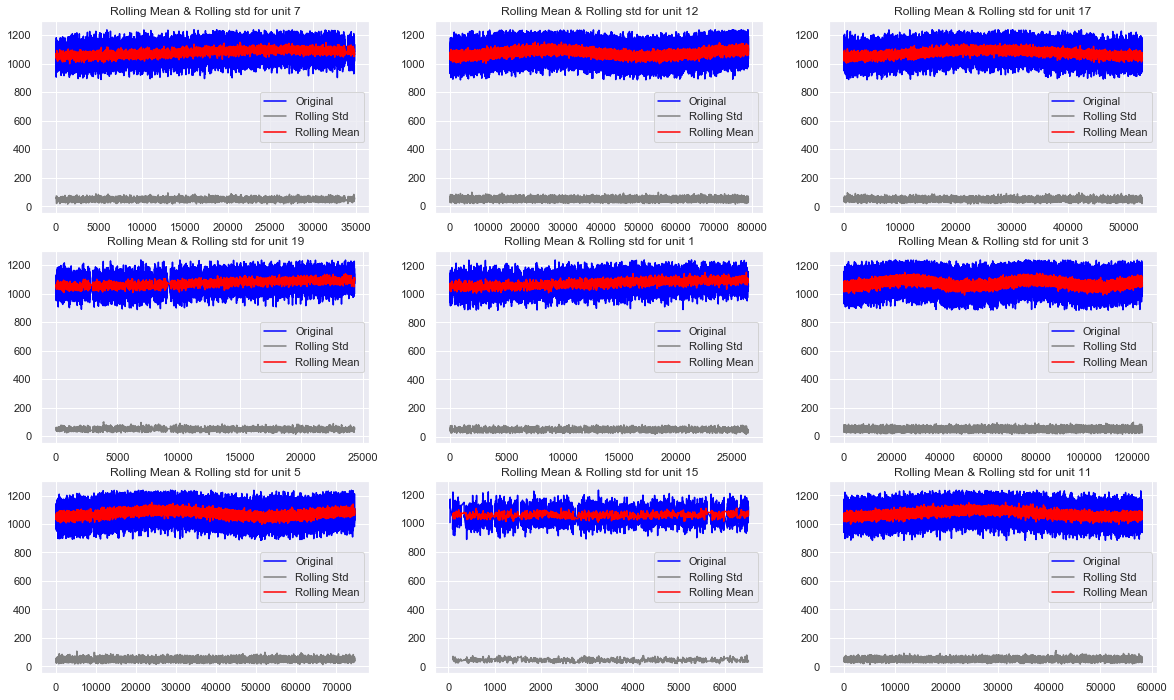

In [77]:
def plot_rolling_meas_stds(feature, window=12, ylim_low=-10, ylim_high=1500):
    units = random.sample(range(0, 20), 9)
    #units = ["000{}".format(num) if num < 10 else "00{}".format(num) for num in random.sample(range(0, 20), 9)]
    file_names = ["../data/processed/train/unit{}_rms_anomaly_excluded.csv".format(unit) for unit in units]
    sns.set()
    f, axs = plt.subplots(3, 3, figsize=(20, 12))
    for idx, unit in enumerate(units):
        ax = plt.subplot(3, 3, idx + 1)
        df_unit = load_unit_data(unit)[[feature]]
        rolling_mean = df_unit.rolling(window=window).mean()
        rolling_std = df_unit.rolling(window=window).std()
        
        ax.plot(df_unit.index, df_unit[feature], color='blue', label='Original')
        ax.plot(rolling_std, color='grey', label='Rolling Std')
        ax.plot(rolling_mean, color='red', label='Rolling Mean')
        ax.legend(loc='best')
        ax.set_title('Rolling Mean & Rolling std for unit {}'.format(unit))
    plt.show()
    
plot_rolling_meas_stds('rpm')

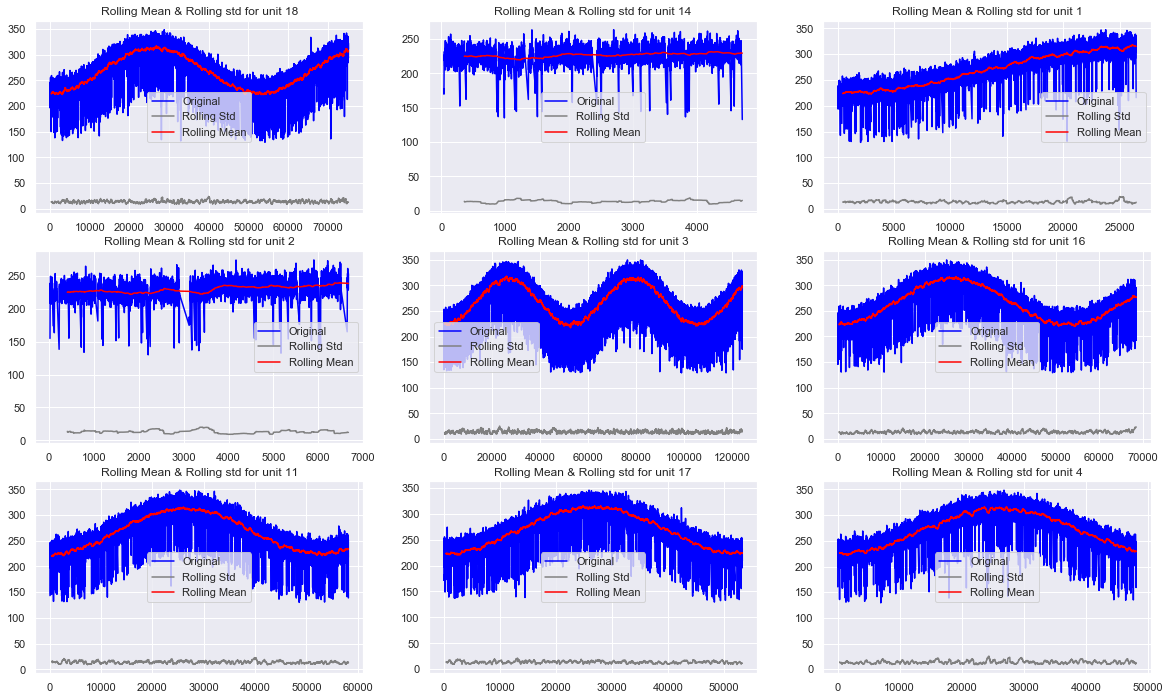

In [87]:
plot_rolling_meas_stds('motor_voltage', window=300)

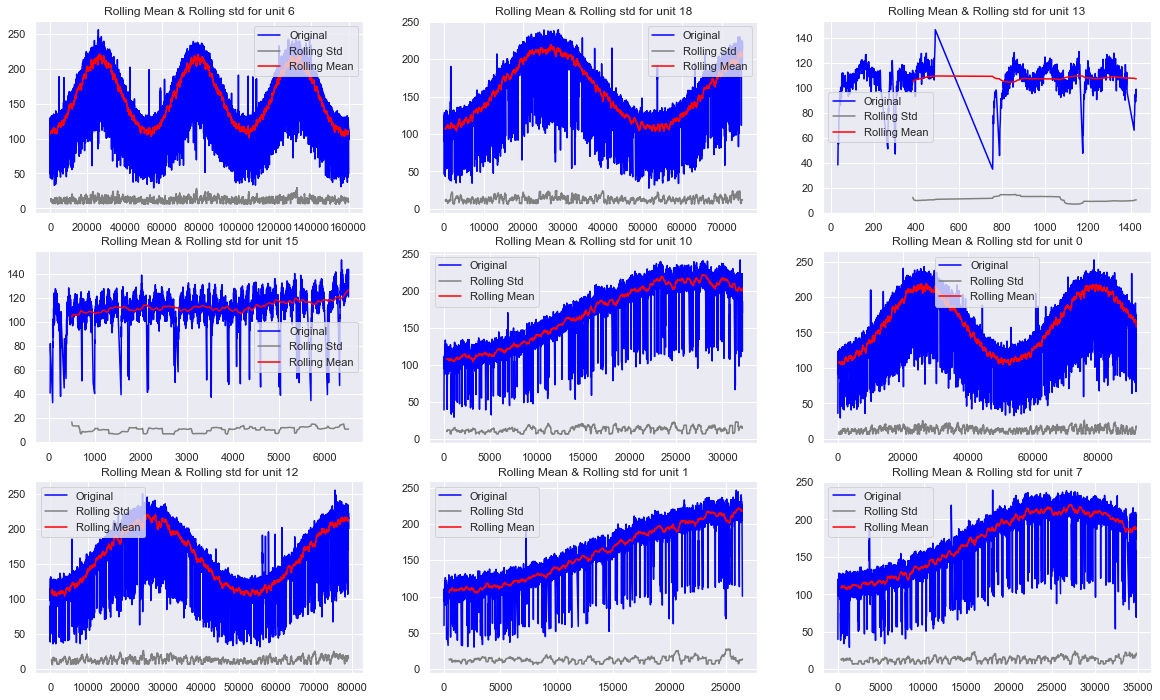

In [88]:
plot_rolling_meas_stds('motor_temp', window=300)

In [2]:
def adfuller_test(unit, feature):
    df_unit = load_unit_data(unit)[[feature]] 
    adf_result = adfuller(df_unit[feature])
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
adfuller_test(18, 'motor_voltage')

ADF Statistic: -3.485992
p-value: 0.008354


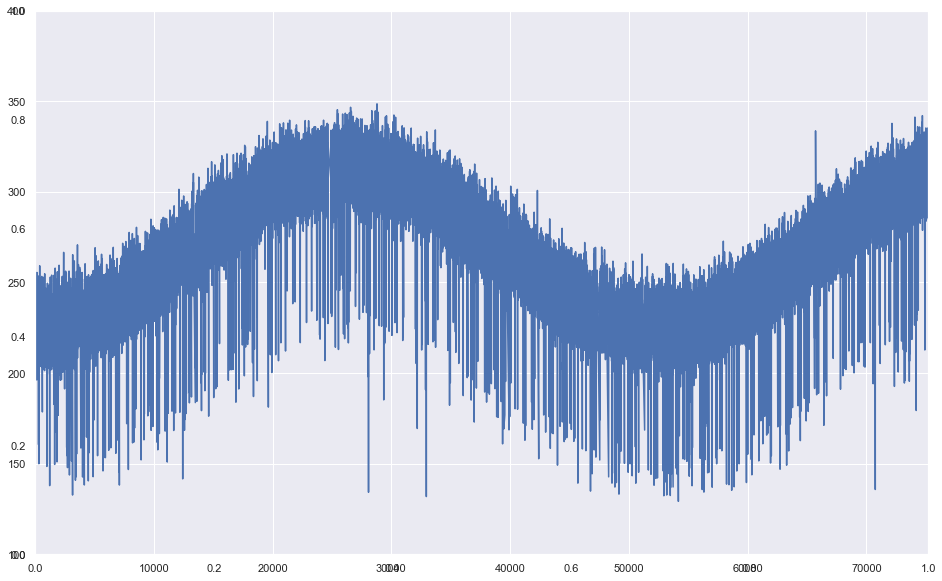

In [10]:
plot_feature_in_single_file("motor_voltage", 18, ylim_low=100, ylim_high=400, bins=100, show_dist=False)

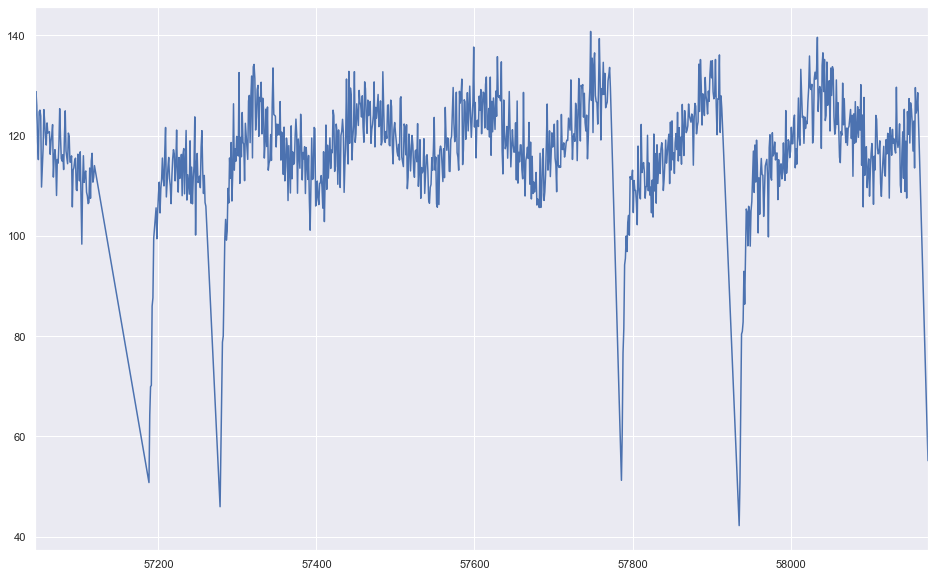

In [4]:
def plot_last_daily_trend(unit, feature, proportion=0.01
                        ):
    df_last_prop = get_last_proportion(unit, feature, proportion=proportion)
    sns.set()
    fig, axs = plt.subplots(figsize=(16, 10))
    df_last_prop[feature].plot()
plot_last_daily_trend(11, 'motor_temp')

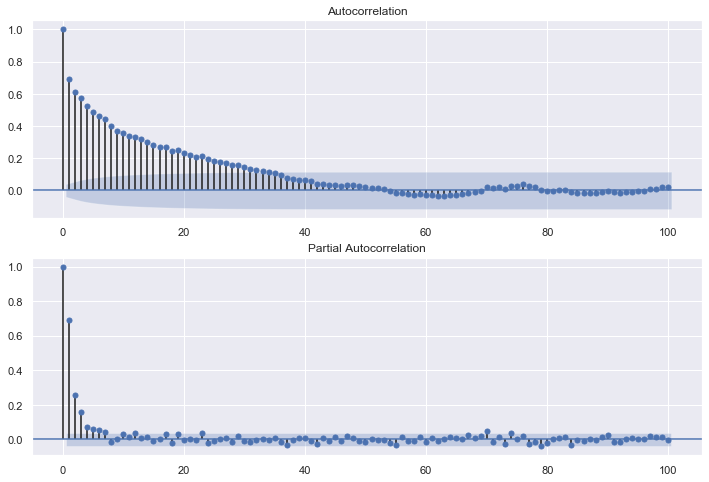

In [134]:
def plot_acf_pacf(unit, feature, lags=50):
    df_last_prop = get_last_proportion(unit, feature, proportion=0.05)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df_last_prop[feature], lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df_last_prop[feature], lags=lags, ax=ax2)
plot_acf_pacf(11, "motor_temp", lags=100)

In [139]:
def grid_search_SARIMAX(unit, feature, val_range=(0, 3), skip_diff=True):
    P = D = Q = range(val_range[0], val_range[1])
    if skip_diff:
        D = [0]
    PDQ = list(itertools.product(P, D, Q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in PDQ]
    #df_unit = load_unit_data(unit)[feature] 
    df_unit = get_last_proportion(unit, feature, proportion=0.05)[feature]
    
    index_p85_input = int(len(df_unit.index) * 0.85)
    train_input = df_unit[:index_p85_input]
    test_input = df_unit[index_p85_input:]
    params_best, param_seasonal_best, AIC_best = None, None, float("inf")
    best_AIC = float("inf")
    for param in PDQ:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_input, order=param, seasonal_order=param_seasonal,
                                                enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()
                if best_AIC > results.aic:
                    params_best, param_seasonal_best, best_AIC = param, param_seasonal, results.aic
                    print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            except Exception as ex:
                print(ex.message)
                continue
    print("best hyperparameters by grid search: ARIMA{}, Seasonal{}".format(params_best, param_seasonal_best))
grid_search_SARIMAX(18, "motor_voltage")

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:38885.54257317255
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:35349.26774460687
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:32726.72157983887
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:24516.276279573347
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:22890.551571125197
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:22782.313844533393
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:22748.113929629042
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:22395.99572591529
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:22320.949523577037
ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:22296.715910217565
ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:22283.55508785249
ARIMA(1, 0, 0)x(2, 0, 2, 12)12 - AIC:22251.249032399246
ARIMA(1, 0, 1)x(0, 0, 2, 12)12 - AIC:22250.57703049187
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:22192.467030027452
ARIMA(1, 0, 1)x(1, 0, 2, 12)12 - AIC:22131.156053335042
ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:22126.72245360854
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:22095.770507111705
ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:22094.040343263678

KeyboardInterrupt: 

In [2]:
def train_SARIMAX(unit, feature, order, seasonal_order):
    #df_unit = load_unit_data(unit)[feature]
    df_unit = get_last_proportion(unit, feature, proportion=0.05)[feature]
    
    index_p85 = int(len(df_unit.index) * 0.85)
    train = df_unit[:index_p85]
    test = df_unit[index_p85:]
    model = SARIMAX(train, trend='n', order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=-1)
    print(model_fit.summary())
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(train, label='actual')
    plt.plot(model_fit.fittedvalues[1:], label='fitted')
    plt_title = "SARIMAX fitted vs actual on {} of unit {}".format(feature, unit)
    plt.title(plt_title)
    plt.legend(loc="upper left")
    return model_fit
model_SARIMAX = train_SARIMAX(18, "motor_voltage", (7, 0, 1), (7, 0, 1, 144))

KeyboardInterrupt: 

In [150]:
df_unit = get_last_proportion(12, 'rpm', proportion=0.05)['rpm']
index_p85 = int(len(df_unit.index) * 0.85)
df_unit[index_p85:].index

Int64Index([78588, 78589, 78590, 78591, 78592, 78593, 78594, 78595, 78596,
            78597,
            ...
            79165, 79166, 79167, 79168, 79169, 79170, 79171, 79172, 79173,
            79174],
           dtype='int64', length=503)

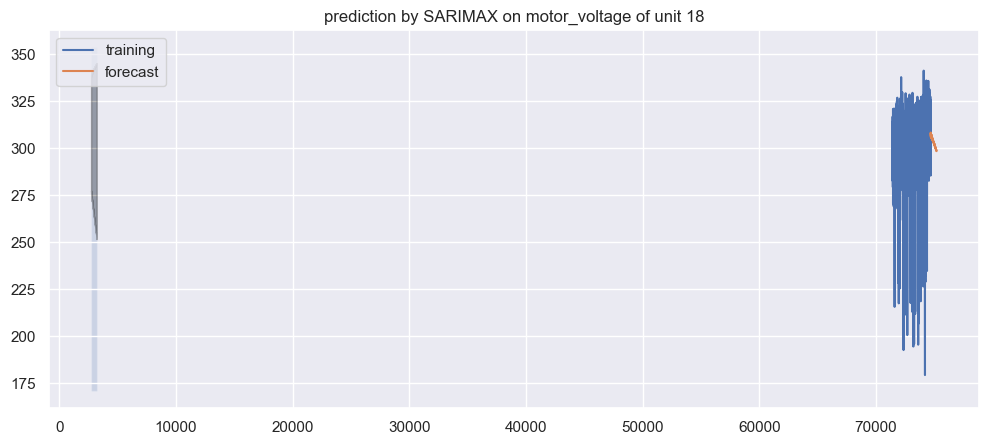

In [172]:
def SARIMAX_predict(model, unit, feature):
    #df_unit = load_unit_data(unit)[feature]
    df_unit = get_last_proportion(unit, feature, proportion=0.05)[feature]
    index_p85 = int(len(df_unit.index) * 0.85)
    #start, end = df_unit.index[index_p85], df_unit.index[-1]
    start, end = index_p85, len(df_unit.index)
    df_last_p15_index = df_unit[(index_p85 - 1):].index
    forecast = model.predict(start=start, end=end, dynamic=True)
    df_forecast = pd.DataFrame(forecast, index=df_last_p15_index)
    forecast = pd.DataFrame(forecast.values, index=df_last_p15_index.tolist())
    #print(forecast.values.flatten())

    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 5), dpi=100)
    predict = model.get_prediction(start=start, end=end, dynamic=False)
    pred_ci = predict.conf_int()

    ax = sns.lineplot(x=df_unit[:index_p85 + 2].index, y=df_unit[:index_p85 + 2].values, label='training')
    #ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.3)
    #ax.fill_betweenx(ax.get_ylim(), pred_ci.index[0], pred_ci.index[-1], alpha=.2, zorder=-1)
    sns.lineplot(x=forecast.index, y=forecast.values.flatten(), label='forecast')
    plt_title = "prediction by SARIMAX on {} of unit {}".format(feature, unit)
    plt.title(plt_title)
    plt.legend(loc='upper left')
SARIMAX_predict(model_SARIMAX, 18, "motor_voltage")